# 2D Convolutional Neural Networks

In this lab, we will train a traditional VGG16 model, where we will train the last couple of layers to adapt it to our problem. We will also study how to use Pytorch directly, without Keras, and [torchvision](https://pytorch.org/vision/main/), the image subpackage from torch.

The problem is to predict one of 6 categories of pictures, whether they are. 'buildings', 'forest', 'glacier', 'mountain', 'sea' or 'street'. This problem comes from an Intel Image Classification challenge and is available [here](https://www.kaggle.com/puneet6060/intel-image-classification/version/2).


In [ ]:
from IPython.display import Image

import numpy as np
import h5py as h5py
import PIL
import os

# Others
import numpy as np
from sklearn.model_selection import train_test_split

# For AUC estimation and ROC plots
from sklearn.metrics import roc_curve, auc

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Torch
import torch
import torchvision


Now, we can load the data.

In [ ]:
!gdown 'https://drive.google.com/uc?id=1HEB7JHl6uSANiENvaHBxhzmkkZ9YlhEC'

In [ ]:
!unzip IntelClassification.zip

Let's see a couple of examples.

In [ ]:
Image(filename='IntelClassification/seg_train/sea/17997.jpg')

In [ ]:
Image(filename='IntelClassification/seg_train/street/8294.jpg')

Finally, let's verify torch is running on GPU. The following code gets that and also allocates the device (the GPU) to a variable.

In [4]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The default device is set to {device}")

Is CUDA supported by this system? True
CUDA version: 11.7
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA A100-SXM4-40GB
The default device is set to cuda


All good! Now we can run our models in GPU.

## VGG16

The VGG 16 model is a classic model in Deep Learning. It is a 16 layer model, following the structure that we discussed in the lectures.

This model was trained over the ImageNet data, thus looking to classify among 1000 different types of objects, over a very large database of images. We can leverage these already-trained weights, and  adapt just the last few layers for our purposes.

We start by loading the VGG16 model. Torch comes pre-packaged with a series of models, loaded into the [Models library in torchvision](https://pytorch.org/vision/main/models.html). We start by first loading the model on-the-fly using the library. We can check the options of the model in the options of the function [VGG16](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html#torchvision.models.vgg16).

This will download the model and save it to our unoriginally named variable model. It is a pretty beefy download, at around 500MB. Luckly we have fast internet in Colab :). It uses the default weights which were pretrained by Torch.

We then move the model to the GPU.

In [19]:
# Load the model from pytorch using default weights.
model = torchvision.models.vgg16(weights=None)
checkpoint = torch.load('vgg16-397923af.pth')
model.load_state_dict(checkpoint)
print(f"This model is trained for {model.classifier[6].out_features} classes")

# Move to the GPU
model.to(device)

This model is trained for 1000 classes


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We now show the basic structure of the model.

In [20]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Due to the structure of torch, visualizing models is hard. We can however use some packages to print models. They are a bit experimental, so careful on complex models. This one though is simple.

In [ ]:
!pip install torchview

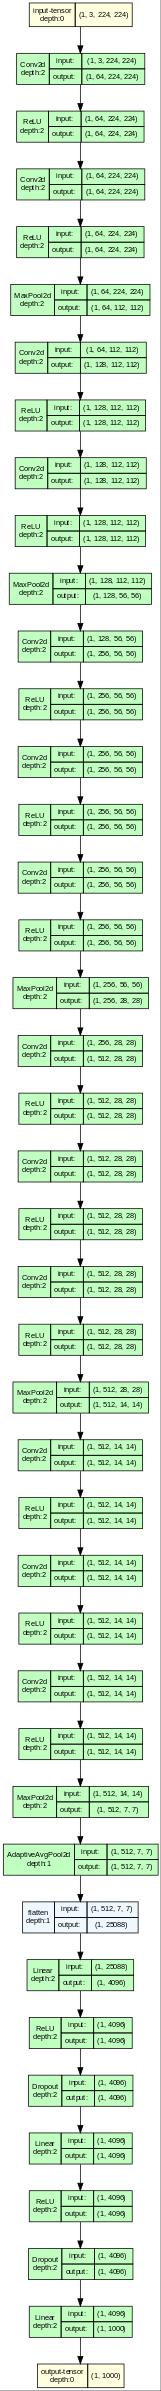

In [13]:
from torchview import draw_graph
import graphviz
%matplotlib inline
graphviz.set_jupyter_format('jpg')

model_graph = draw_graph(model, input_size=(1,3,224,224), device='meta')
model_graph.visual_graph

At this point, every single parameter is trainable. We don't need this, as we want to use the parameters that come with the model. We will change the model to first keep all convolutional layers constant, and we will also change the "top" of the model, that is, the layers that lead to classification. These are the ones that are above the "Flatten" layer.

The following code does that.

In [21]:
# List the indexes of the top layers
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [22]:
# Freeze training for all layers
for param in model.features.parameters():
    param.require_grad = False

In [23]:
# Replace the top layer. Reduce size to 128 and output layer to 6.
model.classifier[0] = torch.nn.Linear(in_features=25088, out_features=128, bias=True)
model.classifier[3] = torch.nn.Linear(in_features=128, out_features=128, bias=True)
model.classifier[6] = torch.nn.Linear(in_features=128, out_features=6, bias=True)

# Move to the GPU
model.to(device)
print(next(model.parameters()).is_cuda) # Should say True

True


In [24]:
# Check the new model if it worked.
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Ready! We can now load the data. We have our set of pictures ready for this example. For this problem we will use a generator. A generator takes images from a directory, and feeds them to the model as needed. **This is necessary to work with big data**. We cannot expect the datasets we work here to fit in memory, so we take the images as needed.

We will now generate a function to load the training data. This will take a directory and apply augmentations to the data to improve training efficiency. This will use pytorch's [torchvision](https://pytorch.org/vision/stable/index.html) package that comes with functions tailored to image data.

In [32]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Get the transforms for VGG16
transforms_vgg16 = torchvision.models.VGG16_Weights.DEFAULT.transforms

def load_image_data_trainval(data_dir='IntelClassification/seg_train',
                            batch_size=32,
                            validation_split=0.33,
                            random_seed=42):
    """
    Load an image dataset and splits it into training and validation sets.

    Parameters:
    - data_dir (str): Path to the data directory.
    - batch_size (int): Number of images to be loaded in each batch.
    - validation_split (float): The fraction of the dataset to be used as validation set.
    - random_seed (int): A seed to ensure reproducibility for the random split.

    Returns:
    - train_loader (DataLoader): DataLoader for the training set.
    - val_loader (DataLoader): DataLoader for the validation set.
    """

    # Define a transformation pipeline
    transform = transforms.Compose([
        transforms_vgg16()
        ])

    # Create the dataset using ImageFolder
    full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    # Determine the split sizes
    total_size = len(full_dataset)
    val_size = int(validation_split * total_size)
    train_size = total_size - val_size

    # Ensure reproducibility of the split
    torch.manual_seed(random_seed)

    # Split the dataset
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create the DataLoaders to feed data to the model
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

For the test set, we will create a generator that applies no transformations to the data except resizing and centering.

In [33]:
def load_image_test_dataset(data_dir='IntelClassification/seg_test', batch_size=32):
    """
    Load the IntelClassification image dataset.

    Parameters:
    - data_dir (str): Path to the data directory (the directory should contain 'train' and 'test' subdirectories).
    - batch_size (int): Number of images to be loaded in each batch.

    Returns:
    - DataLoader: PyTorch DataLoader for the dataset.
    """

    # Test data has no transformations beyond the basics.
    transforms_list = [
        transforms_vgg16()
    ]

    # Initialize the transformation function
    transform = transforms.Compose(transforms_list)

    # Create the dataset using ImageFolder
    full_data_dir = os.path.join(data_dir)
    dataset = datasets.ImageFolder(root=full_data_dir, transform=transform)

    # Create the DataLoader to feed data to the model
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return dataloader

We must now create our data loaders.

In [34]:
train_loader, val_loader = load_image_data_trainval(batch_size=128)
test_loader = load_image_test_dataset(batch_size=128)

print(f"The train set has {len(train_loader.dataset)} images.")
print(f"The validation set has {len(val_loader.dataset)} images.")
print(f"The test set has {len(test_loader.dataset)} images.")

The train set has 9403 images.
The validation set has 4631 images.
The test set has 3000 images.


Let's visualize a few examples.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


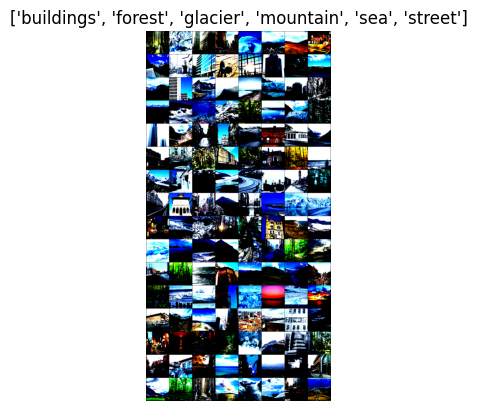

In [35]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[x for x in classes])

# Get a batch of training data
inputs, classes = next(iter(train_loader))
show_databatch(inputs, test_loader.dataset.classes)

Now we can create the train loop. In Pytorch, we must be explicit in each of the operations of the backpropagation algorithm. This allows us to control the training loop explicitely, but it does lead to a somewhat extensive codebase.

The good news is that this is boilerplate and can be copy-pasted with ease for future projects.

In [36]:
# Defining the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Defining the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [37]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs).to(device)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            running_loss = 0.

    return last_loss

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 2

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 10 loss: 0.29344130456447604
  batch 20 loss: 0.28301572501659394
  batch 30 loss: 0.20897505283355713
  batch 40 loss: 0.24434355050325393
  batch 50 loss: 0.23220139741897583
  batch 60 loss: 0.23088791221380234
  batch 70 loss: 0.23074904084205627


The model is able to learn quite well! Let's check the convergence plot.

In [ ]:
loss = CBModel.history.history['loss']
val_loss = CBModel.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As you can see, the model still has much more to learn! Keep training until you get convergence.

Now, let's apply it to the test set and get a confusion matrix.

In [ ]:
# Applying to the test set with a generator.
test_generator.reset()

# Get probabilities
output = CBModel.predict(test_generator)

In [ ]:
output

In [ ]:
# Calculate classes
pred_classes = np.argmax(output, axis=1)

labels = test_generator.classes

In [ ]:
pred_classes

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline

# Calculate confusion matrix
confusion_matrix_net = confusion_matrix(y_true = labels,
                    y_pred = pred_classes)

# Turn matrix to percentages
confusion_matrix_net = confusion_matrix_net.astype('float') / confusion_matrix_net.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_net,
        index=['building', 'forest', 'glacier', 'mountain', 'sea', 'street'],
        columns=['building', 'forest', 'glacier', 'mountain', 'sea', 'street'],
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

Now that we are happy, we can save the model.

In [ ]:
# Saving the model
CBModel.save('/content/VGG16_FM9528A.h5')

# Loading
# CBModel = keras.models.load_model('/content/drive/MyDrive/VGG16_FM9528A.h5')

## Visualizing learning

As a final example. We will visualize the learning, to detect exactly what is happening.

We will use [Grad CAM](https://arxiv.org/abs/1610.02391), a method that allows visualizing how one image activates the neural network. Basically we will look for the direction that the model used to get to its decisions. This requires to do some iterations that we won't explain in detail. Please refer to chapter 5.4 of Chollet's book to check the details.

In [ ]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [ ]:
# Get the image in the right size
def get_img_array(img_path, size = (224, 224)):
    import tensorflow as tf
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    array = preprocess_input(array)
    return array


In [ ]:
# Get an image
img_path = 'IntelClassification/seg_test/forest/20056.jpg'
data = get_img_array(img_path)

# Plot it
display(Image(img_path))

In [ ]:
# The explainer. Gotten from https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    from tensorflow import keras
    import tensorflow as tf
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
# Print the predictions
preds = CBModel.predict(preprocess_input(data/255))
print(preds)

This example shows the model is 99% sure this is a street. Now we need to configure our model. We neeed to get the layers that are used for prediction (i.e. everything after the last convolution) and the last convolutional layer.

Get them with a model.summary()

In [ ]:
CBModel.summary()

In [ ]:
# Set the layers.
last_conv_layer_name = "block5_conv3"
classifier_layer_names =  ["block5_pool",
                           "flatten",
                           "dense",
                           "dense_1",
                           "dense_2",]


In [ ]:
# Plot the heatmap!
heatmap = make_gradcam_heatmap(
    preprocess_input(data/255), CBModel, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Now, to really visualize what's going on, we will superimpose the heatmap over the input. The following code does just that.

In [ ]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "Street_Example.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))


Now we can clearly see what is happening.

This is the importance of the modelling procedures: We need to understand how much diversity we are including in our images: If we don't we might end up learning other things!

Try to change the filters and learning other characteristics.